# Predicting Water Lead Hazards in Chicago, IL
**Team: Valeria Balza, James Midkiff, and Tarren Peterson**

## Section 1. Data Wrangling

Our project relies on three main data sources:
1. Water Quality data from the [City of Chicago Department of Water Management](https://chicagowaterquality.org/DataFiles/wqContent/WQ_Study_and_MeterSave_Results.xlsx) (see *data/water_qual.xlsx* for raw file).
2. American Community Survey Five-Year Estimates (2019)
3. Cook County Assessor's data on [Residential Property Characteristics](https://datacatalog.cookcountyil.gov/Property-Taxation/Cook-County-Assessor-s-Residential-Property-Charac/bcnq-qi2z)
   * This file is very large, so we have saved it to the repository as a zip file at  
   _data/Cook_County_Assessor_s_Residential_Property_Characteristics.zip_
   * Descriptions of the property classes are located [here](https://datacatalog.cookcountyil.gov/Property-Taxation/Cook-County-Assessor-s-Residential-Property-Charac/bcnq-qi2z)

### Water Quality Data

In [2]:
import pandas as pd
import numpy as np
import re
from string import punctuation
import warnings
# Many models give warnings which would be cumbersome to print
warnings.filterwarnings('ignore') 

wdf = pd.read_excel('data/water_qual.xlsx', header=2, sheet_name='Initial', 
                    usecols=[0, 1, 2, 3, 4], skipfooter=6, 
                    dtype={'1st Draw':"str", '2-3 Minute': 'str', '5 Minute': 'str'})
wdf.head(3)

,Date Sampled,Address,1st Draw,2-3 Minute,5 Minute
0,2020-01-26 07:42:00,X N Bishop St,<1.0,<1.0,<1.0
1,2016-11-08 05:30:00,XX N Lasalle St,<1,<1,<1
2,2019-11-07 06:18:00,X W Brayton St,<1.0,6.9,<1.0


In [2]:
print(f'''The earliest sampling date for an initial test is {wdf["Date Sampled"].min().date()} 
and the most recent sampling date is {wdf["Date Sampled"].max().date()}.\n''')
print(f'There are a total of {wdf.shape[0]:,} rows in the initial dataset.')

The earliest sampling date for an initial test is 2016-01-27 
and the most recent sampling date is 2021-01-07.

There are a total of 23,882 rows in the initial dataset.


In [3]:
# Cleaning records
wdf.replace(to_replace="^<\s?[01]\.?.*", value="1.0", inplace=True, regex=True) 
wdf.dropna(subset=["1st Draw"], inplace=True) 
(wdf.drop(wdf[wdf["1st Draw"].str.contains("^\D", regex=True)]
    .index.values, inplace=True))
wdf.loc[:, '1st Draw': '5 Minute'] = (wdf.loc[:,'1st Draw':'5 Minute']
    .astype('float64'))
wdf.loc[:,'1st Draw':'5 Minute'] = (wdf.loc[:,'1st Draw':'5 Minute']
    .mask(wdf.loc[:,'1st Draw':'5 Minute'] < 1, 
        other=1.0))

In [44]:
print('Summary statistics for the 1st sample drawn in initial testing:')
print(wdf['1st Draw'].describe())
print()
print('Summary statistics for the 2nd sample (2-3 Minute Mark) drawn in initial testing:')
print(wdf['2-3 Minute'].describe())
print()
print('Summary statistics for the final sample (5 Minute Mark) drawn in initial testing:')
print(wdf['5 Minute'].describe())

Summary statistics for the 1st sample drawn in initial testing:
count    22668.000000
mean         3.640967
std         13.724032
min          1.000000
25%          1.000000
50%          2.000000
75%          3.800000
max        730.000000
Name: 1st Draw, dtype: float64

Summary statistics for the 2nd sample (2-3 Minute Mark) drawn in initial testing:
count    22667.000000
mean         4.112260
std          6.835936
min          1.000000
25%          1.000000
50%          2.200000
75%          5.400000
max        460.000000
Name: 2-3 Minute, dtype: float64

Summary statistics for the final sample (5 Minute Mark) drawn in initial testing:
count    22667.000000
mean         2.267388
std          3.051567
min          1.000000
25%          1.000000
50%          1.200000
75%          2.500000
max        240.000000
Name: 5 Minute, dtype: float64


In [7]:
wdf["t_high"] = (wdf.loc[:,'1st Draw':'5 Minute'] >= 15).any(axis=1)

print(f'''{wdf["t_high"].sum():,} ({round(wdf["t_high"].sum() / wdf.shape[0] * 100, 2)}%) of the 
total households in the sample had at least one water sample test contain 15.0 or more lead ppb 
in initial testing.''')

1,007 (4.44%) of the 
total households in the sample had at least one water sample test contain 15.0 or more lead ppb 
in initial testing.


In [8]:
# Cleaning addresses for geocoding
wdf.Address.replace({'^XX\s': '10 ', '^X\s': '1 ', 
                     'XX':'00', '[0-9]X':'0'}, regex=True, inplace=True)
wdf.Address = wdf.Address.str.strip(punctuation)
wdf.Address += ', Chicago, IL, USA'

In [9]:
import geopandas as gpd
import geopy
from geopy.extra.rate_limiter import RateLimiter
from geopy.geocoders import Nominatim

# Geocoding Addresses
# Geocoding the +20,000 observations takes substantially long. Please load
# the data/wdf_points.csv to continue working with the geocoded dataset.

# locator = Nominatim(user_agent="myGeocoder")
# location = locator.geocode("Chicago, IL, USA")

# geocode = RateLimiter(locator.geocode, min_delay_seconds=1)
# wdf['location'] = wdf['Address'].apply(geocode)
# wdf['point'] = wdf['location'].apply(lambda loc: tuple(loc.point) if loc else None)
# wdf[['latitude', 'longitude', 'altitude']] = pd.DataFrame(wdf['point'].tolist(), index=wdf.index)
# wdf.drop('altitude', 'point', axis=1, inplace=True)

# wdf.to_csv('data/wdf_points.csv')

In [10]:
# Creating new variables for models
wdf = pd.read_csv('data/wdf_points.csv', index_col=[0])
wdf.drop('Threshold', axis=1, inplace=True)

wdf["max_reading"] = wdf[["1st Draw", "2-3 Minute", '5 Minute']].max(axis=1)
wdf["max_reading"] = wdf["max_reading"].fillna(0)

wdf["t_high"] = np.where(wdf['max_reading'] >= 15, 1, 0)
wdf["t_med"] = np.where(wdf['max_reading'] >= 5, 1, 0)

# Manually cleaning some observations
wdf.loc[wdf["Address"] == "1800 W Chicago Ave , Chicago, IL, USA", ["longitude"]] = -87.67228848673774
wdf.loc[wdf["Address"] == "1800 W Chicago Ave , Chicago, IL, USA", ["latitude"]] = 41.896391737686976
wdf.loc[wdf["Address"] == "1100 W 17th St, Chicago, IL, USA", ["longitude"]] = -87.65310150616693
wdf.loc[wdf["Address"] == "1100 W 17th St, Chicago, IL, USA", ["latitude"]] = 41.862919274995626
wdf.loc[wdf["Address"] == "1600 N 18th St , Chicago, IL, USA", ["longitude"]] = -87.85520742698857
wdf.loc[wdf["Address"] == "1600 N 18th St , Chicago, IL, USA", ["latitude"]] = 41.906865692166896
wdf.loc[wdf["Address"] == "2400 W Harrison Ave, Chicago, IL, USA", ["longitude"]] = -87.68634655975251
wdf.loc[wdf["Address"] == "2400 W Harrison Ave, Chicago, IL, USA", ["latitude"]] = 41.87425757200666
wdf.loc[wdf["Address"] == "800 N Elizabeth St , Chicago, IL, USA", ["longitude"]] = -87.65992222906638
wdf.loc[wdf["Address"] == "800 N Elizabeth St , Chicago, IL, USA", ["latitude"]] = 41.89661964867207

# Converting to geopandas dataframe
wdf_g = gpd.GeoDataFrame(
    wdf, geometry=gpd.points_from_xy(wdf.longitude, wdf.latitude))
wdf_g.to_file('data/water_quality_clean.shp')

### ACS Data

In [13]:
acs_data = pd.read_csv('data/ACS Data.csv')
acs_data.head()

,FIPS,Geographic Identifier,Area Name,Qualifying Name,State Postal Abbreviation,Summary Level,Geographic Component,File identification,Logical Record Number,State (FIPS Code),...,Occupied Housing Units: 3 Rooms,Occupied Housing Units: 4 Rooms,Occupied Housing Units: 5 Rooms,Occupied Housing Units: 6 Rooms,Occupied Housing Units: 7 Rooms,Occupied Housing Units: 8 Rooms,Occupied Housing Units: 9 or More Rooms,Median Year Structure Built,Median Gross Rent,Owner-Occupied Housing Units
0,1.700000e+11,15000US170310101001,Block Group 1,"Block Group 1, Census Tract 101, Cook County, ...",il,150,0,ACSSF,9336,17,...,20,35,50,15,35,0,47,0.0,873.0,117
1,1.700000e+11,15000US170310101002,Block Group 2,"Block Group 2, Census Tract 101, Cook County, ...",il,150,0,ACSSF,9337,17,...,238,310,227,77,23,0,57,0.0,799.0,53
2,1.700000e+11,15000US170310101003,Block Group 3,"Block Group 3, Census Tract 101, Cook County, ...",il,150,0,ACSSF,9338,17,...,216,338,161,97,7,14,41,0.0,1071.0,327
3,1.700000e+11,15000US170310102011,Block Group 1,"Block Group 1, Census Tract 102.01, Cook Count...",il,150,0,ACSSF,9339,17,...,89,206,189,90,0,10,33,1962.0,1097.0,224
4,1.700000e+11,15000US170310102012,Block Group 2,"Block Group 2, Census Tract 102.01, Cook Count...",il,150,0,ACSSF,9340,17,...,221,412,442,125,119,0,19,1945.0,1152.0,353


In [14]:
acs_features = acs_data.iloc[:, [0, 1, 11, 12, 13, 31, 32, 38, 39, 40, 50, 51, 52]].copy()
acs_features.head()

,FIPS,Geographic Identifier,Census Tract,Block Group,Total Population,Total Population: White Alone,Total Population: Black or African American Alone,Average Household Size,Median Household Income (In 2019 Inflation Adjusted Dollars),Occupied Housing Units,Median Year Structure Built,Median Gross Rent,Owner-Occupied Housing Units
0,1.700000e+11,15000US170310101001,10100,1,461,265,108,1.95,NaN,236,0.0,873.0,117
1,1.700000e+11,15000US170310101002,10100,2,2424,746,1543,2.26,21827.0,1054,0.0,799.0,53
2,1.700000e+11,15000US170310101003,10100,3,1714,1137,427,1.50,54297.0,1073,0.0,1071.0,327
3,1.700000e+11,15000US170310102011,10201,1,1706,479,745,2.30,42778.0,712,1962.0,1097.0,224
4,1.700000e+11,15000US170310102012,10201,2,3925,2131,1180,2.69,39535.0,1424,1945.0,1152.0,353


In [15]:
chicago_blocks = gpd.read_file('data/Boundaries - Census Blocks - 2010.geojson')
chicago_blocks['Block Group'] = chicago_blocks['geoid10'].map(lambda x: str(x)[:12])

chicago_groups = chicago_blocks.dissolve(by='Block Group')
chicago_groups.head()

,geometry,statefp10,name10,blockce10,tract_bloc,geoid10,tractce10,countyfp10
Block Group,,,,,,,,
170310101001,"POLYGON ((-87.67009 42.02115, -87.67047 42.021...",17,Block 1000,1000,0101001000,170310101001000,010100,031
170310101002,"POLYGON ((-87.66950 42.01936, -87.66963 42.019...",17,Block 2002,2002,0101002002,170310101002002,010100,031
170310101003,"POLYGON ((-87.66681 42.01924, -87.66780 42.019...",17,Block 3007,3007,0101003007,170310101003007,010100,031
170310102011,"POLYGON ((-87.68234 42.01250, -87.68268 42.012...",17,Block 1008,1008,0102011008,170310102011008,010201,031
170310102012,"POLYGON ((-87.67972 42.01392, -87.68003 42.013...",17,Block 2017,2017,0102012017,170310102012017,010201,031


In [16]:
acs_features["GEOID"] = acs_features["Geographic Identifier"].map(lambda x: str(x)[-12:])
geo_census_features = (gpd.GeoDataFrame(acs_features.merge(chicago_groups.loc[:, ['geometry']],
                                                           left_on="GEOID", right_index=True, how="inner"))) 
geo_census_features.head()

,FIPS,Geographic Identifier,Census Tract,Block Group,Total Population,Total Population: White Alone,Total Population: Black or African American Alone,Average Household Size,Median Household Income (In 2019 Inflation Adjusted Dollars),Occupied Housing Units,Median Year Structure Built,Median Gross Rent,Owner-Occupied Housing Units,GEOID,geometry
0,1.700000e+11,15000US170310101001,10100,1,461,265,108,1.95,NaN,236,0.0,873.0,117,170310101001,"POLYGON ((-87.67009 42.02115, -87.67047 42.021..."
1,1.700000e+11,15000US170310101002,10100,2,2424,746,1543,2.26,21827.0,1054,0.0,799.0,53,170310101002,"POLYGON ((-87.66950 42.01936, -87.66963 42.019..."
2,1.700000e+11,15000US170310101003,10100,3,1714,1137,427,1.50,54297.0,1073,0.0,1071.0,327,170310101003,"POLYGON ((-87.66681 42.01924, -87.66780 42.019..."
3,1.700000e+11,15000US170310102011,10201,1,1706,479,745,2.30,42778.0,712,1962.0,1097.0,224,170310102011,"POLYGON ((-87.68234 42.01250, -87.68268 42.012..."
4,1.700000e+11,15000US170310102012,10201,2,3925,2131,1180,2.69,39535.0,1424,1945.0,1152.0,353,170310102012,"POLYGON ((-87.67972 42.01392, -87.68003 42.013..."


In [17]:
test = geo_census_features.copy()
print('Gross Rent NA %: {:.1f}'.format(len(test.loc[test['Median Gross Rent'].isna()]) / len(test) * 100))
print('Median Home Age NA: % {:.1f}'.format(len(test.loc[test['Median Year Structure Built'].eq(0)]) / len(test) * 100))
print('Median NA %: {:.1f}'.format(len(test.loc[test['Median Household Income (In 2019 Inflation Adjusted Dollars)'].isna()]) / len(test) * 100))
print('Total Pop = 0 %: {:.1f}'.format(len(test.loc[test['Total Population'].eq(0)]) / len(test) * 100))
print('Occupied Units = 0 %: {:.1f}'.format(len(test.loc[test['Occupied Housing Units'].eq(0)]) / len(test) * 100))
print('Owner Occupied Units = 0 %: {:.1f}'.format(len(test.loc[test['Owner-Occupied Housing Units'].eq(0)]) / len(test) * 100))
print('White Alone = 0 %: {:.1f}'.format(len(test.loc[test['Total Population: White Alone'].eq(0)]) / len(test) * 100))
print('Black Alone = 0 %: {:.1f}'.format(len(test.loc[test['Total Population: Black or African American Alone'].eq(0)]) / len(test) * 100))

Gross Rent NA %: 11.3
Median Home Age NA: % 44.4
Median NA %: 6.0
Total Pop = 0 %: 0.3
Occupied Units = 0 %: 0.3
Owner Occupied Units = 0 %: 1.4
White Alone = 0 %: 11.0
Black Alone = 0 %: 16.1


In [18]:
geo_census_features['Percent White'] = np.divide(geo_census_features['Total Population: White Alone'],
                                          geo_census_features['Total Population'])
geo_census_features['Percent Non-White'] = np.subtract(1, geo_census_features['Percent White'])
geo_census_features['Percent African American'] = np.divide(geo_census_features['Total Population: Black or African American Alone'],
                                                     geo_census_features['Total Population'])
geo_census_features['Median Year Structure Built'] = np.where((geo_census_features['Median Year Structure Built'].eq(0)), 
                                                       np.nan, geo_census_features['Median Year Structure Built'])
geo_census_features['Percent Owner Occupied'] = np.divide(geo_census_features['Owner-Occupied Housing Units'],
                                                   geo_census_features['Occupied Housing Units'])

In [19]:
geo_census_features.rename(mapper={'Total Population': 'tot_pop', 
                                   'Total Population: White Alone': 'tot_white', 
                                   'Total Population: Black or African American Alone': 'tot_black', 
                                   'Average Household Size': 'hh_size',
                                   'Median Household Income (In 2019 Inflation Adjusted Dollars)': 'med_income', 
                                   'Occupied Housing Units': 'occ_units',
                                   'Median Year Structure Built': 'med_built_yr',
                                   'Median Gross Rent': 'med_rent',
                                   'Owner-Occupied Housing Units': 'oo_hsng_units',
                                   'Percent White': 'perc_white', 
                                   'Percent Non-White': 'perc_non_white',
                                   'Percent African American': 'perc_black',
                                   'Percent Owner Occupied': 'perc_owner_occ'}, 
                  axis='columns', inplace=True)

In [19]:
# geo_census_features.to_file("data/geo_census.shp")

### Housing Assessment Data
### Block Group-Level

In [4]:
import pipeline_jmidkiff as pipeline
import importlib
importlib.reload(pipeline)

pd.set_option('display.max_rows', 100)

In [5]:
# Loading in the assessment data 
initial_assessments = pd.read_csv(
    'data/Cook_County_Assessor_s_Residential_Property_Characteristics.zip', 
    sep='\t', compression='zip')

pipeline.show(initial_assessments)


Shape:
(1995108, 82)

Data Types:
PIN                                                  int64
Property Class                                       int64
Tax Year                                             int64
Neighborhood Code                                    int64
Land Square Feet                                     int64
Town Code                                            int64
Type of Residence                                  float64
Apartments                                         float64
Wall Material                                      float64
Roof Material                                      float64
Rooms                                              float64
Bedrooms                                           float64
Basement                                           float64
Basement Finish                                    float64
Central Heating                                    float64
Other Heating                                      float64
Central Air          

,PIN,Property Class,Tax Year,Neighborhood Code,Land Square Feet,Town Code,Type of Residence,Apartments,Wall Material,Roof Material,...,Location Factor,Garage indicator,Residential share of building,Pure Market Sale,Pure Market Filter,Neigborhood Code (mapping),Square root of lot size,Square root of age,Square root of improvement size,Town and Neighborhood
0,1011000040000,212,2018,12,11055,10,2.0,5.0,1.0,2.0,...,2.084499,1.0,NaN,0,0,12,105.142760,11.618950,43.634848,1012
1,1011000050000,205,2018,12,6534,10,2.0,0.0,1.0,1.0,...,2.079861,1.0,NaN,0,0,12,80.833162,10.677078,39.522146,1012
2,1011000060000,212,2018,12,6534,10,2.0,3.0,2.0,1.0,...,2.076376,1.0,NaN,0,0,12,80.833162,10.440307,40.951190,1012
3,1011000090000,212,2018,12,13571,10,2.0,2.0,2.0,2.0,...,2.061552,1.0,NaN,0,0,12,116.494635,8.717798,67.416615,1012
4,1011000170000,205,2018,12,9027,10,2.0,0.0,1.0,1.0,...,2.096602,0.0,NaN,0,0,12,95.010526,11.090537,39.799497,1012


In [9]:
# Selecting the most important assessment features given our analysis of the data
col_list = ['Property Address', 'PIN', 'Longitude', 'Latitude', 
            'Property Class', 'Wall Material', 
            'Roof Material', 'Repair Condition', 'Renovation', 
            'Prior Tax Year Market Value Estimate (Land)', 
            'Prior Tax Year Market Value Estimate (Building)', 'Land Square Feet', 
            'Building Square Feet', 'Age']

In [11]:
import geopandas as gpd
# Note that the Assessment data imputes '10' for any houses missing their age. 
# Total Building Square Feet is missing for almost all data

assessments = initial_assessments[col_list]
assessments = gpd.GeoDataFrame(
    assessments, 
    geometry=gpd.points_from_xy(
        assessments['Longitude'], 
        assessments['Latitude']), 
    crs='EPSG:4326')

In [20]:
# Limiting the assessments to located in the ACS geospatial boundaries
assessments_in_chi = gpd.sjoin(
    left_df=geo_census_features.loc[:,['GEOID', 'geometry']], 
    right_df=assessments, how='inner', op='intersects')

In [52]:
# Descriptive Statistics of numerical assessment data
residences = assessments_in_chi.shape[0] # Number of residences in Chicago
descr_col_list = ['Prior Tax Year Market Value Estimate (Land)', 
            'Prior Tax Year Market Value Estimate (Building)', 'Land Square Feet', 
            'Building Square Feet', 'Age', 
            'Property Class', 'Wall Material', 
            'Roof Material', 'Repair Condition', 'Renovation',]
d = {'Column': [], 'Non-Null Values': [], 'Null Values': [], 
     'Mean': [], 'Std. Dev': [], 'Median': [], 'Min': [], 'Max': []}
metric = 'int'
for col in descr_col_list:
    descr = assessments_in_chi[col].describe()
    non_null, mean, std, median, min_desc, max_desc = (
        round(descr['count']), round(descr['mean']), round(descr['std']), 
        round(descr['50%']), round(descr['min']), round(descr['max']))
    if col == 'Property Class': 
        metric = 'str'
    d['Column'].append(col)
    d['Non-Null Values'].append(non_null)
    d['Null Values'].append(residences - non_null) # Total number of residences from above
    if metric != 'str': 
        d['Mean'].append(mean)
        d['Std. Dev'].append(std)
        d['Median'].append(median)
        d['Min'].append(min_desc)
        d['Max'].append(max_desc) 
    else: 
        d['Mean'].append('--')
        d['Std. Dev'].append('--')
        d['Median'].append('--')
        d['Min'].append('--')
        d['Max'].append('--') 
    
descr_df = pd.DataFrame(d)
descr_df

,Column,Non-Null Values,Null Values,Mean,Std. Dev,Median,Min,Max
0,Prior Tax Year Market Value Estimate (Land),728543,0,45602,54501,34320,0,3040940
1,Prior Tax Year Market Value Estimate (Building),728543,0,225590,253792,164960,0,13358380
2,Land Square Feet,728543,0,17032,37369,4495,0,7753680
3,Building Square Feet,438342,290201,1875,1234,1489,0,19992
4,Age,728543,0,71,39,70,1,205
5,Property Class,728543,0,--,--,--,--,--
6,Wall Material,438329,290214,--,--,--,--,--
7,Roof Material,438329,290214,--,--,--,--,--
8,Repair Condition,438329,290214,--,--,--,--,--
9,Renovation,1243,727300,--,--,--,--,--


In [61]:
pipeline.group_count(assessments_in_chi, 'Property Class').to_frame().reset_index()

,Property Class,Count
0,200,38
1,201,4116
2,202,56905
3,203,135822
4,204,9905
5,205,36312
6,206,12035
7,207,5980
8,208,982
9,209,927


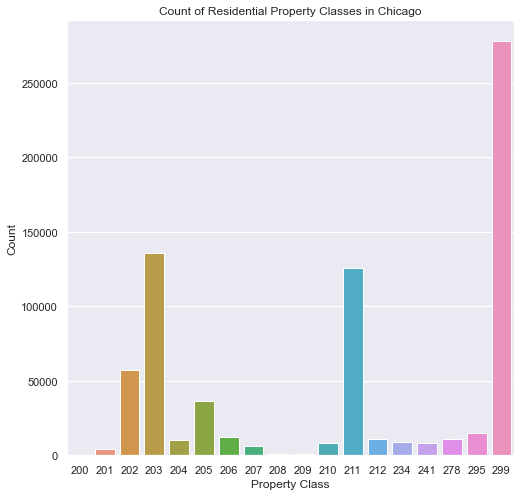

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_theme()
class_counts = pipeline.group_count(assessments_in_chi, 'Property Class').to_frame().reset_index()
class_counts['Proportion'] = class_counts['Count'] / class_counts['Count'].sum()

plt.figure(figsize=(8, 8))
sns.barplot(class_counts['Property Class'], class_counts['Count'])
plt.title('Count of Residential Property Classes in Chicago')
plt.show()

In [72]:
class_counts

,Property Class,Count,Proportion
0,200,38,0.000052
1,201,4116,0.005650
2,202,56905,0.078108
3,203,135822,0.186430
4,204,9905,0.013596
5,205,36312,0.049842
6,206,12035,0.016519
7,207,5980,0.008208
8,208,982,0.001348
9,209,927,0.001272


In [22]:
# One hot encoding the categorical variables
cols_to_dummify = [
    'Property Class', 'Wall Material', 'Roof Material', 'Repair Condition', 
    'Renovation']
assessments_wide = (pd.get_dummies(
        data=assessments_in_chi, columns=cols_to_dummify, dummy_na=True)
    .drop(columns=['Property Address']))
assessments_wide.dtypes

GEOID                                                object
geometry                                           geometry
index_right                                           int64
PIN                                                   int64
Longitude                                           float64
Latitude                                            float64
Prior Tax Year Market Value Estimate (Land)         float64
Prior Tax Year Market Value Estimate (Building)     float64
Land Square Feet                                      int64
Building Square Feet                                float64
Age                                                   int64
Property Class_200.0                                  uint8
Property Class_201.0                                  uint8
Property Class_202.0                                  uint8
Property Class_203.0                                  uint8
Property Class_204.0                                  uint8
Property Class_205.0                    

In [23]:
check = assessments_wide == 0
# Drop any columns that are all 0. 
to_drop = list(check.all()[check.all() == True].index)
assessments_wide.drop(columns=to_drop, inplace=True)
print(f'Dropped the following columns that were all 0:\n{to_drop}')

Dropped the following columns that were all 0:
['Property Class_nan']


In [24]:
cols = list(assessments_wide.columns.values)
cols.pop(cols.index('GEOID'))
assessments_wide = assessments_wide[cols + ['GEOID']]

# First series of aggregations (all that don't use sum()), grouping
# at the block group, GEOID, level
assessments_1a = assessments_wide.groupby(['GEOID']).agg({
    'PIN': 'count', 
    'Prior Tax Year Market Value Estimate (Land)': ['mean', 'median'], 
    'Prior Tax Year Market Value Estimate (Building)': ['mean', 'median'], 
    'Land Square Feet': ['mean', 'median'],
    'Building Square Feet': ['mean', 'median'], 
    'Age': ['mean', 'median']    
})

In [25]:
# Second series of aggregations (all that use sum()), i.e. the one hot encoded
# categories
assessments_1b = (assessments_wide
    .loc[:,'Property Class_200.0':'GEOID']
    .groupby('GEOID').sum())

In [27]:
# Combine the two different data pieces
assessments_block_group = assessments_1a.join(other=assessments_1b)
# There is a total of 2156 block groups present in the data at this point

# Get the proportions for the columns that should have it, dividing by total residences
assessments_block_group.loc[:,'Property Class_200.0':'Renovation_nan'] = (
    assessments_block_group.loc[:,'Property Class_200.0':'Renovation_nan']
        .divide(other=assessments_block_group[('PIN', 'count')], 
                axis=0))

In [28]:
# The final data will use house age from the assessment data and not from the ACS
final_assessments = (geo_census_features.loc[:,[
    'GEOID', 'hh_size', 'med_income', 'occ_units', 'med_rent', 
    'oo_hsng_units', 'perc_white', 'perc_non_white', 'perc_black', 
    'perc_owner_occ', 'tot_pop']]
    .merge(
    right=assessments_block_group, 
    left_on='GEOID', right_index=True))
pipeline.show(final_assessments)
# 2156 block groups


Shape:
(2156, 59)

Data Types:
GEOID                                                         object
hh_size                                                      float64
med_income                                                   float64
occ_units                                                      int64
med_rent                                                     float64
oo_hsng_units                                                  int64
perc_white                                                   float64
perc_non_white                                               float64
perc_black                                                   float64
perc_owner_occ                                               float64
tot_pop                                                        int64
(PIN, count)                                                   int64
(Prior Tax Year Market Value Estimate (Land), mean)          float64
(Prior Tax Year Market Value Estimate (Land), median)        float64
(P

,GEOID,hh_size,med_income,occ_units,med_rent,oo_hsng_units,perc_white,perc_non_white,perc_black,perc_owner_occ,...,Roof Material_5.0,Roof Material_6.0,Roof Material_nan,Repair Condition_1.0,Repair Condition_2.0,Repair Condition_3.0,Repair Condition_nan,Renovation_1.0,Renovation_2.0,Renovation_nan
0,170310101001,1.95,NaN,236,873.0,117,0.574837,0.425163,0.234273,0.495763,...,0.008097,0.000000,0.801619,0.004049,0.190283,0.004049,0.801619,0.000000,0.0,1.000000
1,170310101002,2.26,21827.0,1054,799.0,53,0.307756,0.692244,0.636551,0.050285,...,0.006757,0.000000,0.817568,0.000000,0.175676,0.006757,0.817568,0.000000,0.0,1.000000
2,170310101003,1.50,54297.0,1073,1071.0,327,0.663361,0.336639,0.249125,0.304753,...,0.000000,0.000000,0.924528,0.006289,0.069182,0.000000,0.924528,0.002096,0.0,0.997904
3,170310102011,2.30,42778.0,712,1097.0,224,0.280774,0.719226,0.436694,0.314607,...,0.000000,0.000000,0.625442,0.000000,0.371025,0.003534,0.625442,0.000000,0.0,1.000000
4,170310102012,2.69,39535.0,1424,1152.0,353,0.542930,0.457070,0.300637,0.247893,...,0.004060,0.002706,0.787551,0.000000,0.211096,0.001353,0.787551,0.000000,0.0,1.000000


In [29]:
# Export assessment data block group
# final_assessments.to_csv('data/final_assessments_block_group.csv', sep='\t')

### Block-Level Assessment Data

In [51]:
# Export assessment data at literal block level using address obfuscation 
# like the water set does. 

pipeline.show(assessments_in_chi)


Shape:
(728543, 17)

Data Types:
GEOID                                                object
geometry                                           geometry
index_right                                           int64
Property Address                                     object
PIN                                                   int64
Longitude                                           float64
Latitude                                            float64
Property Class                                        int64
Wall Material                                       float64
Roof Material                                       float64
Repair Condition                                    float64
Renovation                                          float64
Prior Tax Year Market Value Estimate (Land)         float64
Prior Tax Year Market Value Estimate (Building)     float64
Land Square Feet                                      int64
Building Square Feet                                float64
Age   

,GEOID,geometry,index_right,Property Address,PIN,Longitude,Latitude,Property Class,Wall Material,Roof Material,Repair Condition,Renovation,Prior Tax Year Market Value Estimate (Land),Prior Tax Year Market Value Estimate (Building),Land Square Feet,Building Square Feet,Age
0,170310101001,"POLYGON ((-87.67009 42.02115, -87.67047 42.021...",799443,7760 N SHERIDAN RD,11291010331134,-87.666674,42.022737,299,NaN,NaN,NaN,NaN,23470.0,305620.0,61111,NaN,15
0,170310101001,"POLYGON ((-87.67009 42.02115, -87.67047 42.021...",799444,7550 N SHERIDAN RD,11291010331136,-87.666674,42.022737,299,NaN,NaN,NaN,NaN,1180.0,15410.0,61111,NaN,15
0,170310101001,"POLYGON ((-87.67009 42.02115, -87.67047 42.021...",799436,7746 N SHERIDAN RD,11291010331049,-87.666674,42.022737,299,NaN,NaN,NaN,NaN,1180.0,15410.0,61111,NaN,15
0,170310101001,"POLYGON ((-87.67009 42.02115, -87.67047 42.021...",799445,7750 N SHERIDAN RD,11291010331023,-87.666674,42.022737,299,NaN,NaN,NaN,NaN,29630.0,385880.0,61111,NaN,15
0,170310101001,"POLYGON ((-87.67009 42.02115, -87.67047 42.021...",799420,7750 N SHERIDAN RD,11291010331034,-87.666674,42.022737,299,NaN,NaN,NaN,NaN,1180.0,15410.0,61111,NaN,15


In [52]:
assessments_in_chi['Address Obfuscated'] = (
    assessments_in_chi[['Property Address']]
    .replace(to_replace={
        '\d{2}(?=\s)': 'XX', 
        '(?<!\d)\d{1}(?=\s)': 'X'}, regex=True))
addresses = pipeline.group_count(
    df=assessments_in_chi, groupby='Address Obfuscated').sort_index()
pipeline.show(assessments_in_chi)


Shape:
(728543, 18)

Data Types:
GEOID                                                object
geometry                                           geometry
index_right                                           int64
Property Address                                     object
PIN                                                   int64
Longitude                                           float64
Latitude                                            float64
Property Class                                        int64
Wall Material                                       float64
Roof Material                                       float64
Repair Condition                                    float64
Renovation                                          float64
Prior Tax Year Market Value Estimate (Land)         float64
Prior Tax Year Market Value Estimate (Building)     float64
Land Square Feet                                      int64
Building Square Feet                                float64
Age   

,GEOID,geometry,index_right,Property Address,PIN,Longitude,Latitude,Property Class,Wall Material,Roof Material,Repair Condition,Renovation,Prior Tax Year Market Value Estimate (Land),Prior Tax Year Market Value Estimate (Building),Land Square Feet,Building Square Feet,Age,Address Obfuscated
0,170310101001,"POLYGON ((-87.67009 42.02115, -87.67047 42.021...",799443,7760 N SHERIDAN RD,11291010331134,-87.666674,42.022737,299,NaN,NaN,NaN,NaN,23470.0,305620.0,61111,NaN,15,77XX N SHERIDAN RD
0,170310101001,"POLYGON ((-87.67009 42.02115, -87.67047 42.021...",799444,7550 N SHERIDAN RD,11291010331136,-87.666674,42.022737,299,NaN,NaN,NaN,NaN,1180.0,15410.0,61111,NaN,15,75XX N SHERIDAN RD
0,170310101001,"POLYGON ((-87.67009 42.02115, -87.67047 42.021...",799436,7746 N SHERIDAN RD,11291010331049,-87.666674,42.022737,299,NaN,NaN,NaN,NaN,1180.0,15410.0,61111,NaN,15,77XX N SHERIDAN RD
0,170310101001,"POLYGON ((-87.67009 42.02115, -87.67047 42.021...",799445,7750 N SHERIDAN RD,11291010331023,-87.666674,42.022737,299,NaN,NaN,NaN,NaN,29630.0,385880.0,61111,NaN,15,77XX N SHERIDAN RD
0,170310101001,"POLYGON ((-87.67009 42.02115, -87.67047 42.021...",799420,7750 N SHERIDAN RD,11291010331034,-87.666674,42.022737,299,NaN,NaN,NaN,NaN,1180.0,15410.0,61111,NaN,15,77XX N SHERIDAN RD


In [53]:
# I thought about writing a function since I'm copying this code again, 
# but that would have taken away some of the pipeline.show() functionality
# which is important to see the first time through this notebook.  

# Again, dummify
assessments_block_lit_wide = (pd.get_dummies(
        data=assessments_in_chi, columns=cols_to_dummify, dummy_na=True)
    .drop(columns=['Property Address']))

cols = list(assessments_block_lit_wide.columns.values)
cols.pop(cols.index('Address Obfuscated'))
assessments_block_lit_wide = assessments_block_lit_wide[cols + ['Address Obfuscated']]

# First series of aggregations (all that don't use sum())
assessments_block_lit_1a = assessments_block_lit_wide.groupby(['Address Obfuscated']).agg({
    'PIN': 'count', 
    'Prior Tax Year Market Value Estimate (Land)': ['mean', 'median'], 
    'Prior Tax Year Market Value Estimate (Building)': ['mean', 'median'], 
    'Land Square Feet': ['mean', 'median'],
    'Building Square Feet': ['mean', 'median'], 
    'Age': ['mean', 'median']    
})
assessments_block_lit_1a

# Second series of aggregations (all that use sum())
assessments_block_lit_1b = (assessments_block_lit_wide
    .loc[:,'Property Class_200.0':'Address Obfuscated']
    .groupby('Address Obfuscated').sum())
assessments_block_lit_1b

,Property Class_200.0,Property Class_201.0,Property Class_202.0,Property Class_203.0,Property Class_204.0,Property Class_205.0,Property Class_206.0,Property Class_207.0,Property Class_208.0,Property Class_209.0,...,Roof Material_5.0,Roof Material_6.0,Roof Material_nan,Repair Condition_1.0,Repair Condition_2.0,Repair Condition_3.0,Repair Condition_nan,Renovation_1.0,Renovation_2.0,Renovation_nan
Address Obfuscated,,,,,,,,,,,,,,,,,,,,,
100XX S ABERDEEN ST,0.0,0.0,7.0,22.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,2.0,0.0,0.0,37.0,0.0,0.0,0.0,0.0,37.0
100XX S ARTESIAN AVE,0.0,0.0,0.0,7.0,1.0,18.0,3.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,30.0
100XX S AVENUE L,0.0,2.0,7.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,1.0,31.0,0.0,3.0,0.0,0.0,35.0
100XX S AVENUE M,0.0,3.0,11.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.0,0.0,34.0,0.0,5.0,0.0,0.0,39.0
100XX S AVENUE N,0.0,1.0,7.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,15.0,1.0,2.0,0.0,0.0,18.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XX W MAPLE ST,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
XX W MARQUETTE RD,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,3.0
XX W OAK ST,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,45.0,0.0,1.0,0.0,45.0,0.0,0.0,46.0


In [54]:
# Combine the two different data pieces
assessments_block_lit = assessments_block_lit_1a.join(
    other=assessments_block_lit_1b)

# Get the proportions for the columns that should have it, dividing by total residences
assessments_block_lit.loc[:,'Property Class_200.0':'Renovation_nan'] = (
    assessments_block_lit.loc[:,'Property Class_200.0':'Renovation_nan']
        .divide(other=assessments_block_lit[('PIN', 'count')], 
                axis=0))
final_assessments_block_lit = assessments_block_lit

# # Notice I don't export from ACS household median age
# # or the 'total' variables. 
# final_assessments_block_lit = (acs_g.loc[:,[
#     'GEOID', 'hh_size', 'med_income', 'occ_units', 'med_rent', 
#     'oo_hsng_un', 'perc_white', 'perc_non_w', 'perc_black', 'perc_owner']]
#     .merge(
#     right=assessments_block_lit,
#     left_on='GEOID', right_index=True))
pipeline.show(final_assessments_block_lit)

/usr/local/Cellar/jupyterlab/3.0.15_1/libexec/lib/python3.9/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)



Shape:
(25034, 49)

Data Types:
(PIN, count)                                                   int64
(Prior Tax Year Market Value Estimate (Land), mean)          float64
(Prior Tax Year Market Value Estimate (Land), median)        float64
(Prior Tax Year Market Value Estimate (Building), mean)      float64
(Prior Tax Year Market Value Estimate (Building), median)    float64
(Land Square Feet, mean)                                     float64
(Land Square Feet, median)                                   float64
(Building Square Feet, mean)                                 float64
(Building Square Feet, median)                               float64
(Age, mean)                                                  float64
(Age, median)                                                float64
Property Class_200.0                                         float64
Property Class_201.0                                         float64
Property Class_202.0                                         float64
P

,"(PIN, count)","(Prior Tax Year Market Value Estimate (Land), mean)","(Prior Tax Year Market Value Estimate (Land), median)","(Prior Tax Year Market Value Estimate (Building), mean)","(Prior Tax Year Market Value Estimate (Building), median)","(Land Square Feet, mean)","(Land Square Feet, median)","(Building Square Feet, mean)","(Building Square Feet, median)","(Age, mean)",...,Roof Material_5.0,Roof Material_6.0,Roof Material_nan,Repair Condition_1.0,Repair Condition_2.0,Repair Condition_3.0,Repair Condition_nan,Renovation_1.0,Renovation_2.0,Renovation_nan
Address Obfuscated,,,,,,,,,,,,,,,,,,,,,
100XX S ABERDEEN ST,37,27376.216216,24500.0,80191.081081,80770.0,3650.432432,3267.0,1044.513514,1056.0,76.783784,...,0.054054,0.054054,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.0,1.0
100XX S ARTESIAN AVE,30,48554.666667,47500.0,213167.000000,204625.0,5111.066667,5000.0,1509.200000,1345.0,68.766667,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.0,1.0
100XX S AVENUE L,35,24846.285714,25000.0,65371.714286,73960.0,3105.857143,3125.0,2019.812500,2001.5,112.200000,...,0.000000,0.000000,0.085714,0.028571,0.885714,0.000000,0.085714,0.0,0.0,1.0
100XX S AVENUE M,39,26409.743590,25000.0,59992.051282,58410.0,3301.256410,3125.0,1488.411765,1195.0,110.307692,...,0.000000,0.000000,0.128205,0.000000,0.871795,0.000000,0.128205,0.0,0.0,1.0
100XX S AVENUE N,18,26388.888889,25000.0,57832.222222,54750.0,3298.611111,3125.0,1729.687500,1027.0,118.222222,...,0.000000,0.000000,0.111111,0.000000,0.833333,0.055556,0.111111,0.0,0.0,1.0


In [55]:
final_assessments_block_lit[[('PIN', 'count')]].describe()

,"(PIN, count)"
count,25034.000000
mean,29.102141
std,65.096757
min,1.000000
25%,9.000000
50%,22.000000
75%,33.000000
max,3035.000000


In [56]:
# Export assessment data literal block
final_assessments_block_lit.to_csv('data/final_assessments_block_lit.csv', sep='\t')

### Census Block Boundaries

In [30]:
# Downloading Census block boundaries for Chicago
census_gdf = gpd.read_file("https://data.cityofchicago.org/resource/bt9m-d2mf.geojson?$limit=9999999")
census_gdf["GEOID"] = census_gdf["geoid10"].map(lambda x: str(x)[:12])
census_group = census_gdf.dissolve(by='GEOID').reset_index()
census_group.crs = "EPSG:4326"
census_group = census_group[['GEOID', 'geometry']]

In [31]:
# Merging datasets
# MERGED HAS 2156 CENSUS BLOCK GROUP LEVEL
merged = census_group.merge(final_assessments, on ="GEOID", how="inner")
wdf_g.crs = "EPSG:4326"
# WATER LEVEL DATA 21991 TESTS
water_acs = gpd.sjoin(wdf_g, merged, how='inner', op='within')

In [32]:
# Creating aggregate dataset

#### TO BE REVISITED FOR NANS
max_reading = water_acs.groupby('GEOID')['max_reading'].mean().to_frame('mean_reading_blk').reset_index()
sample_cnt = water_acs.groupby('GEOID').size().to_frame('sample_cnt').reset_index()
t_high = water_acs.groupby('GEOID')['t_high'].sum().to_frame('15cnt').reset_index()
t_medium = water_acs.groupby('GEOID')['t_med'].sum().to_frame('5cnt').reset_index()

for_plot = census_group.merge(max_reading, on="GEOID", how="outer")
for_plot = for_plot.merge(sample_cnt, on="GEOID", how="outer")
for_plot = for_plot.merge(final_assessments, on="GEOID", how="outer")
for_plot = for_plot.merge(t_high, on="GEOID", how="outer")
for_plot = for_plot.merge(t_medium, on="GEOID", how="outer")

for_plot['sample_cnt'] = for_plot['sample_cnt'].fillna(0)
for_plot['15cnt'] = for_plot['15cnt'].fillna(0)
for_plot['5cnt'] = for_plot['5cnt'].fillna(0)
for_plot['mean_reading_blk'] = for_plot['mean_reading_blk'].fillna(0)

for_plot['samp_density'] = (for_plot['sample_cnt']/for_plot['tot_pop'])*1000
for_plot['samp_density'] = for_plot['samp_density'].replace(np.infty, 0)
for_plot['samp_density'] = for_plot['samp_density'].fillna(0)
for_plot[['mean_reading_blk', '15cnt', '5cnt']] = for_plot[['mean_reading_blk', '15cnt', '5cnt']].fillna(0)
for_plot['threshold_high'] = np.where(for_plot['15cnt'] >= 1, 1, 0)
for_plot['threshold_medium'] = np.where(for_plot['5cnt'] >= 1, 1, 0)

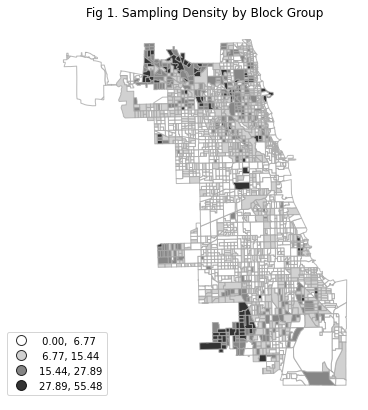

In [33]:
fig = for_plot.plot(column='samp_density',
                        cmap = 'Greys',
                        figsize=(11,7),   
                        scheme='natural_breaks', k=4, 
                        legend = True,
                        edgecolor='darkgrey',
                        alpha=0.8)
    
fig.set_title('Fig 1. Sampling Density by Block Group', 
              fontdict= {'fontsize':12})
fig.set_axis_off()
fig.get_legend().set_bbox_to_anchor((0., 0., 0.2, 0.2))

for legend_handle in fig.get_legend().legendHandles:  
    legend_handle._legmarker.set_markeredgewidth(1)
    legend_handle._legmarker.set_markeredgecolor('k')

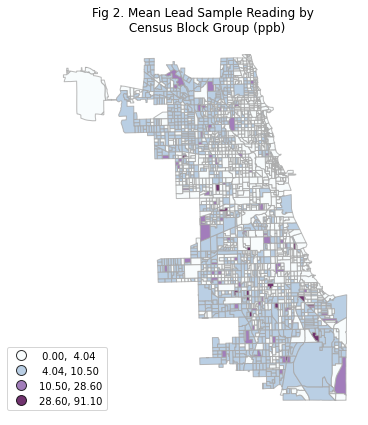

In [34]:
fig = for_plot.plot(column='mean_reading_blk',
                        cmap = 'BuPu',
                        figsize=(11,7),   
                        scheme='natural_breaks', k=4, 
                        legend = True,
                        edgecolor='darkgrey',
                        alpha=0.8)
    
fig.set_title('Fig 2. Mean Lead Sample Reading by \n Census Block Group (ppb)', 
              fontdict= {'fontsize':12})
fig.set_axis_off()
fig.get_legend().set_bbox_to_anchor((0., 0., 0.2, 0.2))

for legend_handle in fig.get_legend().legendHandles:  
    legend_handle._legmarker.set_markeredgewidth(1)
    legend_handle._legmarker.set_markeredgecolor('k')

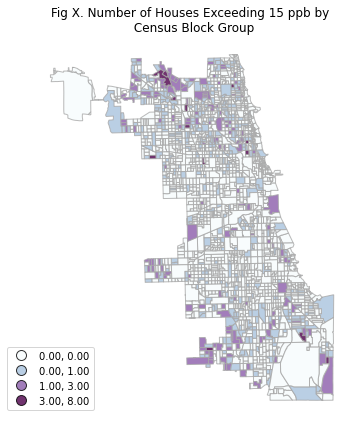

In [35]:
fig = for_plot.plot(column='15cnt',
                        cmap = 'BuPu',
                        figsize=(11,7),   
                        scheme='natural_breaks', k=4, 
                        legend = True,
                        edgecolor='darkgrey',
                        alpha=0.8)
    
fig.set_title('Fig X. Number of Houses Exceeding 15 ppb by \n Census Block Group', 
              fontdict= {'fontsize':12})
fig.set_axis_off()
fig.get_legend().set_bbox_to_anchor((0., 0., 0.2, 0.2))

for legend_handle in fig.get_legend().legendHandles:  
    legend_handle._legmarker.set_markeredgewidth(1)
    legend_handle._legmarker.set_markeredgecolor('k')

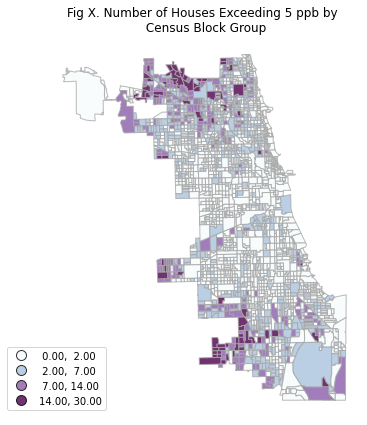

In [36]:
fig = for_plot.plot(column='5cnt',
                        cmap = 'BuPu',
                        figsize=(11,7),   
                        scheme='natural_breaks', k=4, 
                        legend = True,
                        edgecolor='darkgrey',
                        alpha=0.8)
    
fig.set_title('Fig X. Number of Houses Exceeding 5 ppb by \n Census Block Group', 
              fontdict= {'fontsize':12})
fig.set_axis_off()
fig.get_legend().set_bbox_to_anchor((0., 0., 0.2, 0.2))

for legend_handle in fig.get_legend().legendHandles:  
    legend_handle._legmarker.set_markeredgewidth(1)
    legend_handle._legmarker.set_markeredgecolor('k')

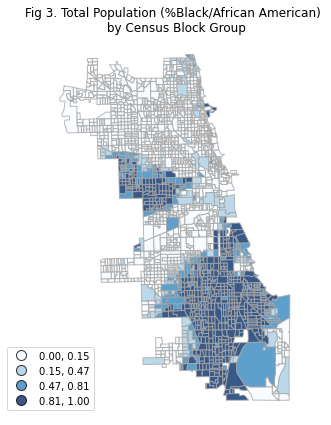

In [37]:
fig = for_plot.plot(column='perc_black',
                        cmap = 'Blues',
                        figsize=(11,7),   
                        scheme='natural_breaks', k=4, 
                        legend = True,
                        edgecolor='darkgrey',
                        alpha=0.8)
    
fig.set_title('Fig 3. Total Population (%Black/African American) \n by Census Block Group', 
              fontdict= {'fontsize':12})
fig.set_axis_off()
fig.get_legend().set_bbox_to_anchor((0., 0., 0.2, 0.2))

for legend_handle in fig.get_legend().legendHandles:  
    legend_handle._legmarker.set_markeredgewidth(1)
    legend_handle._legmarker.set_markeredgecolor('k')

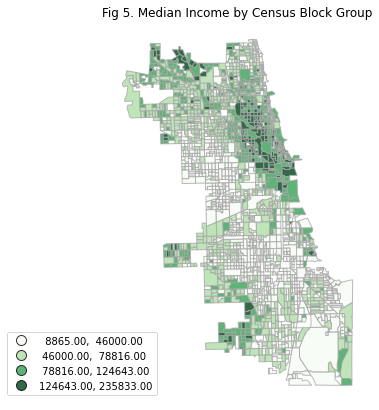

In [38]:
fig = for_plot.plot(column='med_income',
                        cmap = 'Greens',
                        figsize=(11,7),   
                        scheme='natural_breaks', k=4, 
                        legend = True,
                        edgecolor='darkgrey',
                        alpha=0.8)
    
fig.set_title('Fig 5. Median Income by Census Block Group', fontdict= {'fontsize':12})
fig.set_axis_off()
fig.get_legend().set_bbox_to_anchor((0., 0., 0.2, 0.2))

for legend_handle in fig.get_legend().legendHandles:  
    legend_handle._legmarker.set_markeredgewidth(1)
    legend_handle._legmarker.set_markeredgecolor('k')

The range for the water quality dataset is:
Max value: 730.0
Min value: 1.0


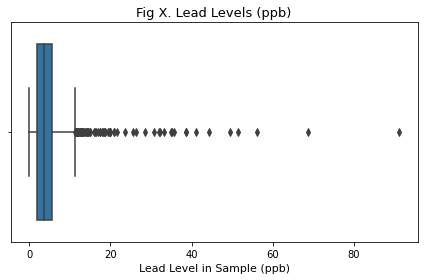

In [39]:
# Descriptive Statistics
import seaborn as sns
import matplotlib.pyplot as plt

print("The range for the water quality dataset is:")
print("Max value: {}\nMin value: {}".format(
    max(wdf_g['max_reading']), min(wdf_g['max_reading'])))

# Data is right-skewed
sampl_distrib = sns.boxplot(x="mean_reading_blk", data=for_plot)
plt.title('Fig X. Lead Levels (ppb)', fontsize=13) 
plt.xlabel('Lead Level in Sample (ppb)', fontsize=11)
plt.tight_layout()

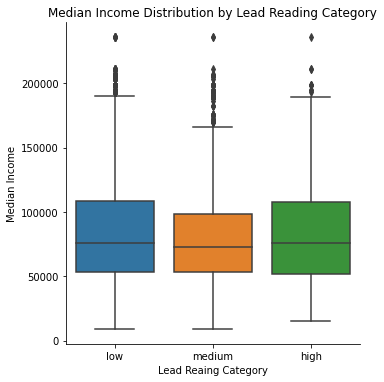

In [40]:
 # Threshold Categorical Variable
import seaborn as sns
def categories(x): 
    if 0 < x < 5:
        return 'low'
    if 5 <= x < 15: 
        return 'medium'
    elif x >= 15:
        return 'high'
    
water_acs['lead_cat'] = water_acs['max_reading'].apply(categories)

med_income = sns.catplot(x="lead_cat", y="med_income", kind='box', data=water_acs, 
                         order=["low", "medium", "high"]) 
labels = med_income.set(xlabel='Lead Reaing Category', ylabel='Median Income',
title='Median Income Distribution by Lead Reading Category')

In [45]:
# FINAL DATASET
sample_cnt = water_acs.groupby('GEOID').size().to_frame('sample_cnt').reset_index()
t_high = water_acs.groupby('GEOID')['t_high'].sum().to_frame('15cnt').reset_index()
t_medium = water_acs.groupby('GEOID')['t_med'].sum().to_frame('5cnt').reset_index()

final = census_group.merge(sample_cnt, on="GEOID", how="outer")
final = final.merge(t_high, on="GEOID", how="outer")
final = final.merge(t_medium, on="GEOID", how="outer")
final = final.merge(final_assessments, on="GEOID", how="outer")
final['threshold_high'] = np.where(for_plot['15cnt'] >= 1, 1, 0)
final['threshold_medium'] = np.where(for_plot['5cnt'] >= 1, 1, 0)
# From 2194 block groups to 2053 block groups
final_df = final[final['sample_cnt'].notna()]
final_df = final_df.drop(['GEOID', 'geometry', '15cnt', '5cnt', 'sample_cnt'], axis=1)
final_df.to_csv('data/final_df.csv')

In [43]:
pipeline.show(final_df)
# final_df.threshold_high.sum(), final_df.threshold_medium.sum()


Shape:
(2053, 60)

Data Types:
hh_size                                                      float64
med_income                                                   float64
occ_units                                                    float64
med_rent                                                     float64
oo_hsng_units                                                float64
perc_white                                                   float64
perc_non_white                                               float64
perc_black                                                   float64
perc_owner_occ                                               float64
tot_pop                                                      float64
(PIN, count)                                                 float64
(Prior Tax Year Market Value Estimate (Land), mean)          float64
(Prior Tax Year Market Value Estimate (Land), median)        float64
(Prior Tax Year Market Value Estimate (Building), mean)      float64
(P

,hh_size,med_income,occ_units,med_rent,oo_hsng_units,perc_white,perc_non_white,perc_black,perc_owner_occ,tot_pop,...,Roof Material_nan,Repair Condition_1.0,Repair Condition_2.0,Repair Condition_3.0,Repair Condition_nan,Renovation_1.0,Renovation_2.0,Renovation_nan,threshold_high,threshold_medium
0,1.95,NaN,236.0,873.0,117.0,0.574837,0.425163,0.234273,0.495763,461.0,...,0.801619,0.004049,0.190283,0.004049,0.801619,0.000000,0.0,1.000000,0,1
2,1.50,54297.0,1073.0,1071.0,327.0,0.663361,0.336639,0.249125,0.304753,1714.0,...,0.924528,0.006289,0.069182,0.000000,0.924528,0.002096,0.0,0.997904,0,0
3,2.30,42778.0,712.0,1097.0,224.0,0.280774,0.719226,0.436694,0.314607,1706.0,...,0.625442,0.000000,0.371025,0.003534,0.625442,0.000000,0.0,1.000000,0,1
4,2.69,39535.0,1424.0,1152.0,353.0,0.542930,0.457070,0.300637,0.247893,3925.0,...,0.787551,0.000000,0.211096,0.001353,0.787551,0.000000,0.0,1.000000,0,1
5,2.99,52948.0,611.0,1023.0,114.0,0.465461,0.534539,0.326206,0.186579,1824.0,...,0.694190,0.000000,0.305810,0.000000,0.694190,0.000000,0.0,1.000000,0,1
